In [2]:
# importing libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from keras import regularizers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
import cv2
from keras.regularizers import l2, l1

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve

plt.style.use('fivethirtyeight')


In [3]:
train_data_path = '../data/aug_red_eye/training_aug/train'
val_data_path = '../data/aug_red_eye/training_aug/val'
test_data_path = '../data/aug_red_eye/training_aug/test'

In [4]:
# define the classes for training
classes = os.listdir(train_data_path)
print(classes)
X_list = []
y_list = []
for class_ in classes:
    files = os.listdir(train_data_path + '/' + class_)
    #print(files)
    for file in files:
        img = load_img(path=train_data_path + '/' + class_+'/'+f'{file}',target_size=(128,128))
        x = np.array(img)
        X_list.append(x)
        y_list.append(class_)
        
X = np.array(X_list)/255
y = np.array(y_list)

['normal_eye_aug', 'red_eye_aug']


In [5]:
y_series = pd.Series(y).map({classes[0]:0, classes[1]:1})
y = to_categorical(y_series)
#print(y_series)

In [6]:
# define the classes for val
classes = os.listdir(val_data_path)

X_list = []
y_list = []
for class_ in classes:
    files = os.listdir(val_data_path + '/' + class_)
    #print(files)
    for file in files:
        img = load_img(path=val_data_path + '/' + class_+'/'+f'{file}',target_size=(128,128))
        x = np.array(img)
        X_list.append(x)
        y_list.append(class_)
        
X_val = np.array(X_list)/255
y_val = np.array(y_list)

In [7]:
y_series_val = pd.Series(y_val).map({classes[0]:0, classes[1]:1})
y_val = to_categorical(y_series_val)

In [8]:
#print(y_val)

In [9]:
K.clear_session()

#defining the CNN2D model
model = Sequential([

    Conv2D(filters= 6, kernel_size=(3,3), strides=(1,1), input_shape=X[0].shape,
           activation=keras.activations.relu,
           padding='valid',kernel_regularizer=l2(0.0001)), # valid means no padding  #

    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding= 'valid'),
    
    Conv2D(filters = 16, kernel_size=(3,3),strides=(1,1),
           activation=keras.activations.relu, 
           padding = 'valid',kernel_regularizer=l2(0.0001)), # valid means no padding #,kernel_regularizer=l2(0.0001)
    
    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding= 'valid'), # valid means no padding
    
    Flatten(),
    
    # Fully connected dense layer with relu activation function
    Dropout(0.3),
    Dense(units=64, activation=keras.activations.relu),
    BatchNormalization(),
    
    # Fully connected dense layer with relu activation function
#     Dropout(0.2),
#     Dense(units=128, activation=keras.activations.relu),
#     BatchNormalization(),

    # Fully connected dense layer with relu activation function
    Dropout(0.3),
    Dense(units=32, activation=keras.activations.relu),
    BatchNormalization(),

    # Fully connected dense layer with relu activation function
    Dropout(0.3),
    Dense(units=16, activation=keras.activations.relu),
    BatchNormalization(),

    # Fully connected output layer with softmax
    Dense(units=2, activation=keras.activations.sigmoid)   # How many neurons? we want classify two classes
    
])

In [10]:
# compling the model
model.compile(optimizer=keras.optimizers.Adam(0.5e-4), 
                loss=keras.losses.binary_crossentropy, metrics=['accuracy','Recall','Precision'])

cb = keras.callbacks.EarlyStopping(monitor="accuracy",
                                    min_delta=0.005,
                                    patience=30,
                                    verbose=1,
                                    mode="min",
                                    baseline=None,
                                    restore_best_weights=False)


In [11]:
history = model.fit(X,y,
        batch_size = 50, 
        epochs = 150,
        verbose = 1, 
        validation_data = (X_val, y_val))

Epoch 1/150
19/19 [==============================] - 10s 49ms/step - loss: 0.9554 - accuracy: 0.4995 - recall: 0.5163 - precision: 0.5083 - val_loss: 0.6962 - val_accuracy: 0.5148 - val_recall: 0.0947 - val_precision: 0.5517
Epoch 2/150
19/19 [==============================] - 0s 14ms/step - loss: 0.8576 - accuracy: 0.5922 - recall: 0.5364 - precision: 0.5398 - val_loss: 0.6929 - val_accuracy: 0.4970 - val_recall: 0.1598 - val_precision: 0.4821
Epoch 3/150
19/19 [==============================] - 0s 17ms/step - loss: 0.8185 - accuracy: 0.6122 - recall: 0.5732 - precision: 0.5714 - val_loss: 0.6921 - val_accuracy: 0.5030 - val_recall: 0.3964 - val_precision: 0.5276
Epoch 4/150
19/19 [==============================] - 0s 15ms/step - loss: 0.7916 - accuracy: 0.6417 - recall: 0.5985 - precision: 0.5856 - val_loss: 0.6849 - val_accuracy: 0.5444 - val_recall: 0.3077 - val_precision: 0.5977
Epoch 5/150
19/19 [==============================] - 0s 14ms/step - loss: 0.7663 - accuracy: 0.6344 - r

In [12]:
train_score = model.evaluate(X, y)
print('val_loss =', train_score[0])
print('val_accuracy =', train_score[1])

30/30 [==============================] - 0s 7ms/step - loss: 0.0262 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000
val_loss = 0.0261890459805727
val_accuracy = 1.0


In [13]:
val_score = model.evaluate(X_val, y_val)
print('val_loss =', val_score[0])
print('val_accuracy =', val_score[1])

6/6 [==============================] - 0s 11ms/step - loss: 0.3732 - accuracy: 0.8343 - recall: 0.8343 - precision: 0.8494
val_loss = 0.3731519281864166
val_accuracy = 0.834319531917572


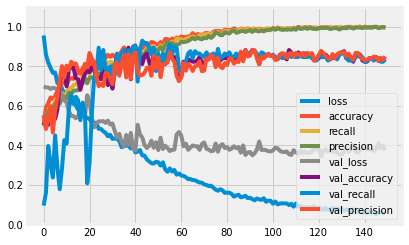

In [14]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(0,1.1) # set the y range to [0,1]
plt.show()


# To save the model

#model.save(r"..\models\model.h5")

In [15]:
# define the classes for val
classes = os.listdir(test_data_path)

X_list = []
y_list = []
for class_ in classes:
    files = os.listdir(test_data_path + '/' + class_)
    #print(files)
    for file in files:
        img = load_img(path=test_data_path + '/' + class_+'/'+f'{file}',target_size=(128,128))
        x = np.array(img)
        X_list.append(x)
        y_list.append(class_)
        
X_test = np.array(X_list)/255
y_test = np.array(y_list)

y_series_test = pd.Series(y_test).map({classes[0]:0, classes[1]:1})
print(len(y_series_test))
y_test = to_categorical(y_series_test)


11


In [16]:
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)
cf_matrix = confusion_matrix(y_series_test, y_pred)
print(cf_matrix)

1/1 [==============================] - 0s 140ms/step
[[5 0]
 [2 4]]


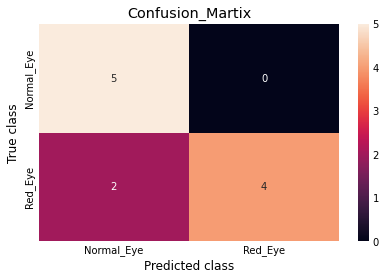

In [17]:
LABELS = ["Normal_Eye","Red_Eye"]
sns.heatmap(cf_matrix, annot=True, xticklabels=LABELS, yticklabels=LABELS,fmt = 'd')
plt.title("Confusion_Martix")
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.show()

In [18]:
print()
print('Model Evalution Score')
print(model.evaluate(X_test, y_test))


Model Evalution Score
1/1 [==============================] - 0s 28ms/step - loss: 0.3009 - accuracy: 0.8182 - recall: 0.8182 - precision: 0.8182
[0.30090489983558655, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141]


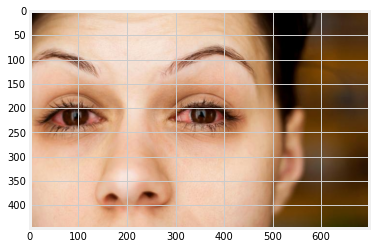

In [19]:
image = cv2.imread('../data/aug_red_eye/prediction_images/prediction/Red2.jpg') #
RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)
plt.show()

In [20]:
image = cv2.resize(image, (128,128), interpolation=cv2.INTER_AREA)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
incomming_image = np.array(image)/255
incomming_image_exp = np.expand_dims(incomming_image, axis = 0)

y_pred = model.predict(incomming_image_exp)
print(y_pred)
if y_pred[0][0] > y_pred[0][1]: 
    print(f'Normal Eye : prediction accuracy {round((y_pred[0][0]),2)*100}%')
else:
    print(f'Red Eye : prediction accuracy {round((y_pred[0][1]),2)*100}%')

1/1 [==============================] - 0s 62ms/step
[[0.05807657 0.9036194 ]]
Red Eye : prediction accuracy 89.99999761581421%
